### Sift descriptor with bag-of-words

---

In this notebook I use sift descriptor to descrive the image, than I use kmeans to cluster this descriptors. The idea is that each cluster will be representing a visual word, if an image is added then the SIFT descriptor will be used to describe the image followed by kmeans prediction that will tell wich word represents each SIFT vector that describes the image.

Than finally I count the ocorrences of each visual word, by doing so, creating an histogram.
 
---

In [1]:
!gdown 1--sv3E5TBFujQcv7mDEeAGLzOh0eOl8e
!gdown 1Ny8CKH1lLUMNhvzWy6oeqPXCGxWTwBoa

Downloading...
From: https://drive.google.com/uc?id=1--sv3E5TBFujQcv7mDEeAGLzOh0eOl8e
To: /content/celeb_data_resized_200.zip
100% 170M/170M [00:01<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ny8CKH1lLUMNhvzWy6oeqPXCGxWTwBoa
To: /content/celeb_data_resized_200.csv
100% 1.02M/1.02M [00:00<00:00, 83.4MB/s]


In [2]:
%%capture
!unzip celeb_data_resized_200.zip 

In [3]:
%%capture
!pip install -U opencv-python

In [4]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import randrange
from skimage import io
from PIL import Image 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [14]:
df = pd.read_csv('celeb_data_resized_200.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.rename(columns={'y2': 'y1'},inplace=True)
df.head(1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,img_location,x0,y0,x1,y1
0,celeb_data_resized/000001.jpg,46.454765,20.669579,156.968216,111.790398


In [16]:
feature_extractor = cv2.SIFT_create()

In [34]:
L_sift = []
L_sift_p = []

for imagem in tqdm(df['img_location']):
  imagem_data = io.imread(imagem) 
  imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2GRAY)
  sift_points, sift_vectors = feature_extractor.detectAndCompute(imagem_data, None)
  L_sift.append(sift_vectors)
  L_sift_p.append(sift_points)

  0%|          | 0/10040 [00:00<?, ?it/s]

In [35]:
def to_points_arrya(cur_lp_sift):
  return [list(cur_l.pt) for cur_l in cur_lp_sift]

In [36]:
L_sift_p = [to_points_arrya(cur_sift_p) for cur_sift_p in L_sift_p]
L_sift_p = [[list(i) for i in cur_sift_p] for cur_sift_p in L_sift_p]


In [40]:
df['sift'] = L_sift
df['sift_p'] = L_sift_p

In [41]:
df.to_pickle('sift_gray_p.pkl')

## Agrupamento dos descritores SIFT para geração de Visual Words

In [ ]:
X_sift = []
for _, row in df.iterrows():
  for sift_vector in row['sift']:
    X_sift.append(sift_vector)

In [ ]:
X_sift = np.array(X_sift)
X_sift.shape

(8171529, 128)

## Agrupamento de descritores

O número de bag of visual words descreverá o número de palavras visuais.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
num_visual_words = 1024
kmeans = MiniBatchKMeans(n_clusters=num_visual_words, n_init=1, max_iter=100, init='random', verbose=1)
kmeans.fit(X_sift)

A saída de streaming foi truncada nas últimas 5000 linhas.
Minibatch step 11059/798000: mean batch inertia: 62472.78125, ewa inertia: 62963.201249566104
Minibatch step 11060/798000: mean batch inertia: 62623.8046875, ewa inertia: 62963.116187875195
Minibatch step 11061/798000: mean batch inertia: 61052.734375, ewa inertia: 62962.63739602682
Minibatch step 11062/798000: mean batch inertia: 63014.08203125, ewa inertia: 62962.65028940332
Minibatch step 11063/798000: mean batch inertia: 61462.0390625, ewa inertia: 62962.27419682423
Minibatch step 11064/798000: mean batch inertia: 61142.76171875, ewa inertia: 62961.81817921736
Minibatch step 11065/798000: mean batch inertia: 61647.90234375, ewa inertia: 62961.488877405944
Minibatch step 11066/798000: mean batch inertia: 61557.43359375, ewa inertia: 62961.13698428177
Minibatch step 11067/798000: mean batch inertia: 61347.69921875, ewa inertia: 62960.73261440932
Minibatch step 11068/798000: mean batch inertia: 63011.1796875, ewa inertia: 6296

MiniBatchKMeans(init='random', n_clusters=1024, n_init=1, verbose=1)

In [ ]:
import pickle

filename = 'kmeans_model_for_BOVW_clustering.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
df_visual_words = pd.DataFrame(X_sift)
df_visual_words.head(1)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,56.0,79.0,12.0,17.0,77.0,9.0,0.0,2.0,170.0,47.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [ ]:
df_visual_words['visual_word'] = kmeans.labels_
df_visual_words.head(5)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,visual_word
0,56.0,79.0,12.0,17.0,77.0,9.0,0.0,2.0,170.0,47.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,132
1,58.0,8.0,4.0,4.0,1.0,1.0,1.0,33.0,58.0,28.0,...,15.0,71.0,22.0,0.0,0.0,1.0,3.0,2.0,3.0,881
2,75.0,70.0,5.0,6.0,9.0,5.0,6.0,12.0,125.0,37.0,...,0.0,62.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,505
3,56.0,89.0,5.0,0.0,0.0,20.0,28.0,5.0,132.0,59.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,120
4,153.0,25.0,2.0,1.0,0.0,0.0,0.0,22.0,148.0,17.0,...,14.0,4.0,11.0,1.0,1.0,1.0,0.0,0.0,1.0,144


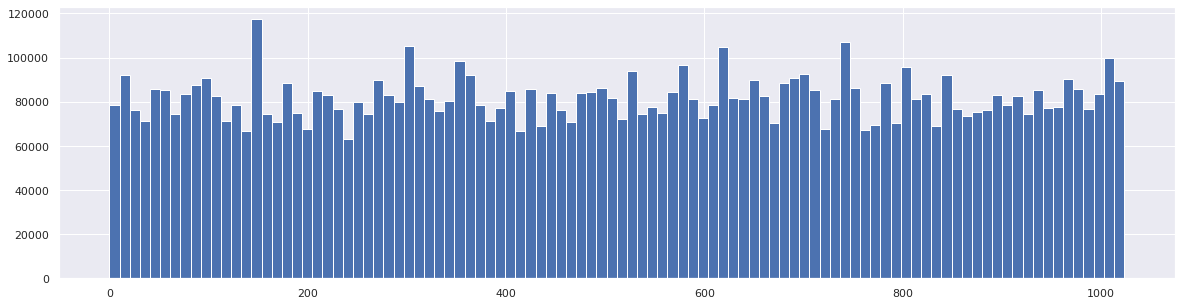

In [ ]:
import seaborn as sns

sns.set_theme()

plt.rcParams["figure.figsize"] = (20,5)
df_visual_words.visual_word.hist(bins=100)

## Now we need to generate the histogram of each image based on the "words" that describes the image

In [ ]:
L_histogram = []
for index,row in tqdm(df.iterrows(),total=len(df)):
  histogram = kmeans.predict(np.array(row['sift']))
  histogram = np.histogram(histogram,num_visual_words)[0]
  L_histogram.append(histogram)

  0%|          | 0/10040 [00:00<?, ?it/s]

In [ ]:
df['visual_words_histogram'] = L_histogram
df.head(1)

,img_location,x0,y0,x1,y2,sift,visual_words_histogram
0,celeb_data_resized/000001.jpg,111.49144,49.606987,376.723694,268.296936,"[[56.0, 79.0, 12.0, 17.0, 77.0, 9.0, 0.0, 2.0,...","[3, 0, 0, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 0, 11,..."


In [ ]:
df['visual_words_histogram'] = [list(cur_hist) for cur_hist in df['visual_words_histogram']] 

In [ ]:
df.rename(columns={'y2':'y1'},inplace=True)

In [ ]:
df['visual_words_histogram'] = df['visual_words_histogram'].apply(lambda x: list(np.array(x)/len(x)))

In [ ]:
df[['img_location', 'x0', 'y0', 'x1', 'y1', 'visual_words_histogram']].to_csv('celeb_with_visual_words.csv', index=False)

In [ ]:
test_df = pd.read_csv('celeb_with_visual_words.csv')